In [1]:
#!/bin/env python3

In [2]:
import graph_tool.all as gt

In [3]:
from graph_tool.flow import edmonds_karp_max_flow as gt_max_flow

In [4]:
import numpy as np

In [5]:
sample_input = """5
9 22 21 15 13
0 5 4 4 2
5 0 5 4 3
4 5 0 2 5
4 4 2 0 7
2 3 5 7 0""".split('\n')

In [6]:
inp = iter(sample_input)

In [7]:
n_teams = int(next(inp))

In [8]:
teams = []
wins = [] # list to store wins_of(v) at index v
matches = {}
remaining = np.zeros(n_teams*n_teams).reshape(n_teams,n_teams) # rem[i,j] = rem[j,i] = remaining games of teams i,j

In [9]:
nextline = next(inp).split() # read in the next line containing wins

In [10]:
g = gt.Graph(directed=True)

In [11]:
draw_scale = 6

In [12]:
cap = g.new_edge_property("int")
name = g.new_vertex_property("string")
pos = g.new_vertex_property("vector<float>")

In [13]:
for i in range(n_teams):
    teams.append(None)
    wins.append(int(nextline[i]))
    if i:
        teams[i] = g.add_vertex()
        pos[teams[i]] = (draw_scale*5,draw_scale*i)
        name[teams[i]] = str(i)        
print(*zip(teams,wins))

(None, 9) (<Vertex object with index '0' at 0x7fe6ec0f6930>, 22) (<Vertex object with index '1' at 0x7fe6ec0f64b0>, 21) (<Vertex object with index '2' at 0x7fe6ec0f6b10>, 15) (<Vertex object with index '3' at 0x7fe6ec0f6b70>, 13)


In [14]:
counter = 0
for i in range(n_teams):
    nextline = next(inp).split() # read in the next line games remaining with particular team
    for j in range(i+1,n_teams):
        remaining[i,j] = remaining[j,i] = triangular[i,j] = int(nextline[j])
        if not i: continue
        matches[tuple(sorted((i,j)))] = g.add_vertex()
        pos[matches[tuple(sorted((i,j)))]] = (draw_scale*3,draw_scale*counter)
        name[matches[tuple(sorted((i,j)))]] = str((i,j))
        counter += 1

In [15]:
print(remaining, '\n', wins)

[[0. 5. 4. 4. 2.]
 [5. 0. 5. 4. 3.]
 [4. 5. 0. 2. 5.]
 [4. 4. 2. 0. 7.]
 [2. 3. 5. 7. 0.]] 
 [9, 22, 21, 15, 13]


In [16]:
source = g.add_vertex()
pos[source] = (draw_scale*0,draw_scale*n_teams//2)
name[source] = 's'
sink = g.add_vertex()
pos[sink] = (draw_scale*7,draw_scale*n_teams//2+1)
name[sink] = 't'

In [17]:
constraint = remaining[0].sum() + wins[0]
for team in range(1,n_teams):
    e = g.add_edge(source=teams[team], target=sink)
    cap[e] = constraint - wins[team]
    for connection in range(team+1,n_teams):
        e = g.add_edge(source=source, target=matches[team,connection])
        cap[e] = remaining[team,connection]
        e1 = g.add_edge(source=matches[team,connection], target=teams[team])
        cap[e1] = remaining[team,connection]
        e2 = g.add_edge(source=matches[team,connection], target=teams[connection])
        cap[e2] = remaining[team,connection]
g.edge_properties["cap"] = cap
g.vertex_properties["pos"] = pos

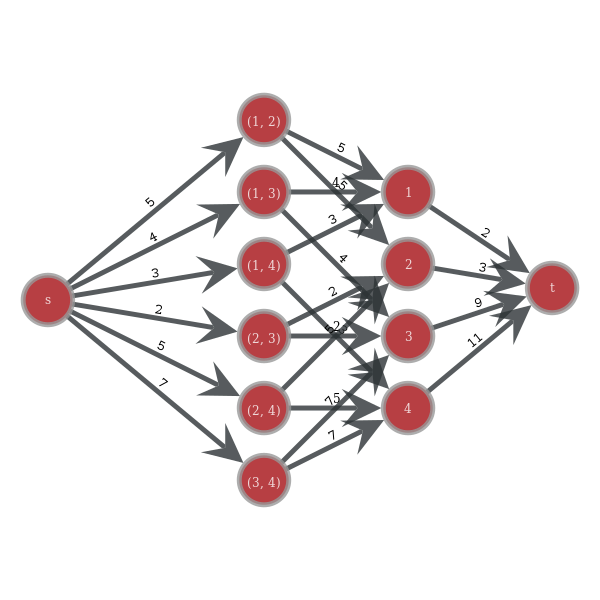

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fe6ec08a278, at 0x7fe6ec08a978>

In [18]:
gt.graph_draw(g,pos=pos,eprops={"text":cap},vprops={"text":name})

In [19]:
res = gt_max_flow(g, source=source, target=sink, capacity=cap)

In [20]:
flow = g.new_edge_property("int")
for e in g.get_edges():
    flow[e] = cap[e] - res[e]

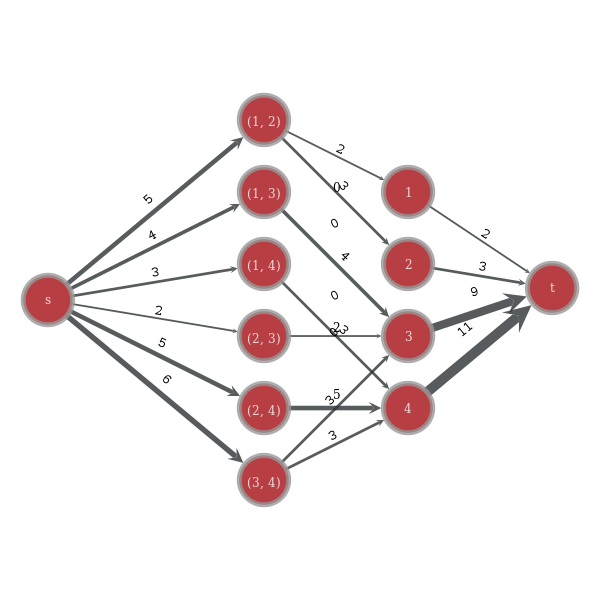

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fe6ec08a278, at 0x7fe6ec08a978>

In [21]:
gt.graph_draw(g, pos=pos, edge_pen_width=gt.prop_to_size(flow, mi=0, ma=10, power=1), eprops={"text":flow},vprops={"text":name})

In [22]:
totalflow = 0
totalcap = 0
for m in matches.values():
    totalcap += cap[g.edge(source,m)]
    totalflow += flow[g.edge(source,m)]
print("total games:",totalcap,"\ttotal played:",totalflow,'\n\n',"team 0 tie/win possible?", totalcap==totalflow)

total games: 26 	total played: 25 

 team 0 tie/win possible? False
